# Import Libraries

In [1]:
import csv
import re
import pylab
import time
import collections
import numpy as np
import nltk
nltk.download('punkt')
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Mounted at /content/gdrive


# Initialize Variables

In [ ]:
#Initialise variables to be used later
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2= [20, 1]
FILTER_SHAPE3 = [20, 20]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
 
batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01
 
seed = 10
tf.random.set_seed(seed)

#Initialise variables for RNN
HIDDEN_SIZE = 20

In [ ]:
#Initialise additional needed variable
EMBEDDING_SIZE = 20

# Pre-processing 

## Char Preprocessing

In [ ]:
#Define functions to be used later
#Get all the unique characters used in the string supplied
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

#Preprocess strings and truncate if length longer than 100
def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

#Read in the data in the train and test csv files
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('/content/gdrive/My Drive/Colab Notebooks/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('/content/gdrive/My Drive/Colab Notebooks/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = read_data_chars()

#Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


## Word Preprocessing

In [ ]:
#Define functions used for word classifier
def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text


def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict


def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x


def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('/content/gdrive/My Drive/Colab Notebooks/train_medium.csv', encoding='utf-8') as filex:
    #with open('train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))
    with open('/content/gdrive/My Drive/Colab Notebooks/test_medium.csv', encoding='utf-8') as filex:   
    #with open('test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size


#Read in the dataset and vocab size
x_train_word, y_train_word, x_test_word, y_test_word, vocab_size_word = read_data_words()

# Use `tf.data` to batch and shuffle the dataset:
train_ds_word = tf.data.Dataset.from_tensor_slices(
    (x_train_word, y_train_word)).shuffle(10000).batch(batch_size)
test_ds_word = tf.data.Dataset.from_tensor_slices((x_test_word, y_test_word)).batch(batch_size)

# Training & Testing Step Functions

## T&T for CNNs

In [ ]:
# Training and Testing step function for CNN models

#Training function
def train_step(model, x, label, drop_rate):
    #Computes gradient from the recorded "tape"
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

#Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

## T&T for RNNs

In [ ]:
def train_step_2(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object_2(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

# Testing function
def test_step_2(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object_2(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

# CharCNN Model w/ Dropout

In [ ]:
tf.keras.backend.set_floatx('float32')
class CharCNN(Model):
    def __init__(self, vocab_size=256):
        super(CharCNN, self).__init__()
        self.vocab_size = vocab_size
        #Weight variables and CNN cell
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        #forward
        x = tf.one_hot(x, one_hot_size)
        x = x[..., tf.newaxis] 
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

In [ ]:
#Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Select metrics to measure the loss and the accuracy of the model. 
#These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


#Char CNN model with dropout
CharCNN_dropout_model = CharCNN(256)

test_acc_CharCNN_dropout = []
train_acc_CharCNN_dropout= []
test_loss_CharCNN_dropout=[]
train_loss_CharCNN_dropout=[]

charCNN_dropout_timer = 0



for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    epoch_start_time = time.perf_counter()
    for images, labels in train_ds:
        train_step(CharCNN_dropout_model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(CharCNN_dropout_model, images, labels, drop_rate=0)

    epoch_end_time = time.perf_counter()
    charCNN_dropout_timer = charCNN_dropout_timer + epoch_end_time - epoch_start_time
    
    test_acc_CharCNN_dropout.append(test_accuracy.result())
    train_acc_CharCNN_dropout.append(train_accuracy.result())
    test_loss_CharCNN_dropout.append(test_loss.result())
    train_loss_CharCNN_dropout.append(train_loss.result())

    if ( (epoch+1)%50 == 0 ): 
        print('[Epoch {}]'.format(epoch+1))
        print('⏵Train Loss: {}'.format(train_loss.result()))
        print('⏵Train Acc:  {}'.format(train_accuracy.result()))
        print('⏵Test Loss:  {}'.format(test_loss.result()))
        print('⏵Test Acc:   {}'.format(test_accuracy.result()))
        print('')

print('Time Taken: {} seconds.'.format(charCNN_dropout_timer))

[Epoch 50]
⏵Train Loss: 0.3561769723892212
⏵Train Acc:  0.8817856907844543
⏵Test Loss:  2.298327684402466
⏵Test Acc:   0.6371428370475769

[Epoch 100]
⏵Train Loss: 0.28054487705230713
⏵Train Acc:  0.9125000238418579
⏵Test Loss:  3.092275857925415
⏵Test Acc:   0.6285714507102966

[Epoch 150]
⏵Train Loss: 0.2904159724712372
⏵Train Acc:  0.9132142663002014
⏵Test Loss:  3.285663366317749
⏵Test Acc:   0.6114285588264465

[Epoch 200]
⏵Train Loss: 0.26559045910835266
⏵Train Acc:  0.920714259147644
⏵Test Loss:  3.3942623138427734
⏵Test Acc:   0.631428599357605

[Epoch 250]
⏵Train Loss: 0.26267683506011963
⏵Train Acc:  0.9208928346633911
⏵Test Loss:  3.6909172534942627
⏵Test Acc:   0.6114285588264465

Time Taken: 129.68128447000527 seconds.


## Pickle Dump

In [ ]:
instanced_variables = [test_acc_CharCNN_dropout, train_acc_CharCNN_dropout, test_loss_CharCNN_dropout, train_loss_CharCNN_dropout, charCNN_dropout_timer]

# create directory in your gdrive
filename = f'/content/gdrive/My Drive/Colab Output/Part_B_Q5_CharCNN_Dropout_variables'
outfile = open(filename,'wb')
pickle.dump(instanced_variables, outfile)
outfile.close()

In [4]:
# Retrieve previously saved instanced variables w/ pickle rick
infile = open(f'/content/gdrive/My Drive/Colab Output/Part_B_Q5_CharCNN_Dropout_variables', 'rb')
retrieved_variables = pickle.load(infile)
infile.close()

# Load retrieved variables into instance variables for plotting
test_acc_CharCNN, train_acc_CharRNN, test_loss_CharCNN, train_loss_CharCNN, charCNN_timer = retrieved_variables

In [6]:
# get highest accuracy values
highest_acc = max(test_acc_CharCNN)

# get average accuracy
average_acc = sum(test_acc_CharCNN)/len(test_acc_CharCNN)

print('Highest Acc')
print(highest_acc)

print('')

print('Avg Acc')
print(average_acc)

Highest Acc
tf.Tensor(0.6542857, shape=(), dtype=float32)

Avg Acc
tf.Tensor(0.62101156, shape=(), dtype=float32)


## CharCNN Plot

### CharCNN Accuracy

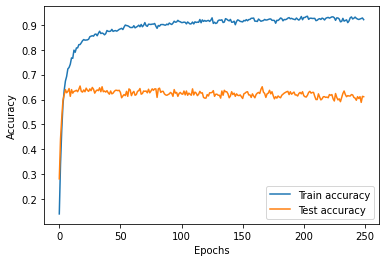

In [ ]:
plt.plot(train_acc_CharCNN_dropout,label="Train accuracy")
plt.plot(test_acc_CharCNN_dropout,label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

### CharCNN Loss

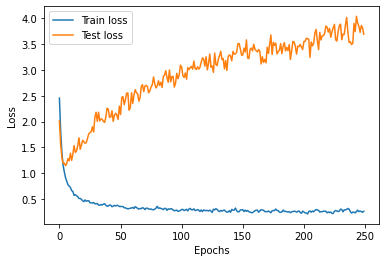

In [ ]:
plt.plot(train_loss_CharCNN_dropout,label="Train loss")
plt.plot(test_loss_CharCNN_dropout,label="Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

# WordCNN Model w/ Dropout

In [ ]:
#Define WordCNN Model
class WordCNN(Model):
    def __init__(self, vocab_size=256):
        super(WordCNN, self).__init__()
        self.vocab_size = vocab_size
        #Weight variables, embedding layer & CNN cell
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE3, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        #forward

        #x = tf.one_hot(x, 256)
        x = self.embedding(x)
        x = x[..., tf.newaxis]
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

In [ ]:
#Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Select metrics to measure the loss and the accuracy of the model. 
#These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Word CNN model with dropout
WordCNN_dropout_model = WordCNN(vocab_size_word)

test_acc_WordCNN_dropout = []
train_acc_WordCNN_dropout= []
test_loss_WordCNN_dropout=[]
train_loss_WordCNN_dropout=[]

wordCNN_dropout_timer = 0



for epoch in range(no_epochs):

    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    epoch_start_time = time.perf_counter()
    for images, labels in train_ds_word:
        train_step(WordCNN_dropout_model, images, labels, drop_rate=0.5)

    for images, labels in test_ds_word:
        test_step(WordCNN_dropout_model, images, labels, drop_rate=0)

    epoch_end_time = time.perf_counter()
    wordCNN_dropout_timer = wordCNN_dropout_timer + epoch_end_time - epoch_start_time

    test_acc_WordCNN_dropout.append(test_accuracy.result())
    train_acc_WordCNN_dropout.append(train_accuracy.result())
    test_loss_WordCNN_dropout.append(test_loss.result())
    train_loss_WordCNN_dropout.append(train_loss.result())

    if ( (epoch+1)%50 == 0 ): 
        print('[Epoch {}]'.format(epoch+1))
        print('⏵Train Loss: {}'.format(train_loss.result()))
        print('⏵Train Acc:  {}'.format(train_accuracy.result()))
        print('⏵Test Loss:  {}'.format(test_loss.result()))
        print('⏵Test Acc:   {}'.format(test_accuracy.result()))
        print('')

print('Time Taken: {} seconds.'.format(wordCNN_dropout_timer))

[Epoch 50]
⏵Train Loss: 0.24334503710269928
⏵Train Acc:  0.9508928656578064
⏵Test Loss:  1.8457242250442505
⏵Test Acc:   0.7471428513526917

[Epoch 100]
⏵Train Loss: 0.39676597714424133
⏵Train Acc:  0.9517857432365417
⏵Test Loss:  2.384500741958618
⏵Test Acc:   0.7699999809265137

[Epoch 150]
⏵Train Loss: 0.5664955377578735
⏵Train Acc:  0.9305357336997986
⏵Test Loss:  2.596106767654419
⏵Test Acc:   0.7485714554786682

[Epoch 200]
⏵Train Loss: 0.8798759579658508
⏵Train Acc:  0.9208928346633911
⏵Test Loss:  3.0937185287475586
⏵Test Acc:   0.7457143068313599

[Epoch 250]
⏵Train Loss: 0.9146032929420471
⏵Train Acc:  0.9169642925262451
⏵Test Loss:  3.1004350185394287
⏵Test Acc:   0.7528571486473083

Time Taken: 257.7786520959926 seconds.


## Pickle Dump

In [ ]:
instanced_variables = [test_acc_WordCNN_dropout, train_acc_WordCNN_dropout, test_loss_WordCNN_dropout, train_loss_WordCNN_dropout, wordCNN_dropout_timer]

# create directory in your gdrive
filename = f'/content/gdrive/My Drive/Colab Output/Part_B_Q5_WordCNN_Dropout_variables'
outfile = open(filename,'wb')
pickle.dump(instanced_variables, outfile)
outfile.close()

In [7]:
# Retrieve previously saved instanced variables w/ pickle rick
infile = open(f'/content/gdrive/My Drive/Colab Output/Part_B_Q5_WordCNN_Dropout_variables', 'rb')
retrieved_variables = pickle.load(infile)
infile.close()

# Load retrieved variables into instance variables for plotting
test_acc_WordCNN, train_acc_WordCNN, test_loss_WordCNN, train_loss_WordCNN, wordCNN_timer = retrieved_variables

In [8]:
# get highest accuracy values
highest_acc = max(test_acc_WordCNN)

# get average accuracy
average_acc = sum(test_acc_WordCNN)/len(test_acc_WordCNN)

print('Highest Acc')
print(highest_acc)

print('')

print('Avg Acc')
print(average_acc)

Highest Acc
tf.Tensor(0.79142857, shape=(), dtype=float32)

Avg Acc
tf.Tensor(0.74875396, shape=(), dtype=float32)


## WordCNN Plot

### WordCNN Accuracy

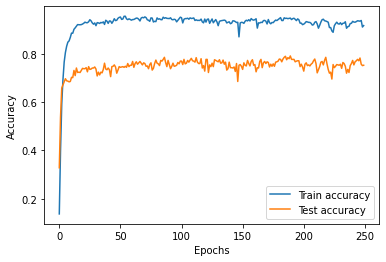

In [ ]:
plt.plot(train_acc_WordCNN_dropout,label="Train accuracy")
plt.plot(test_acc_WordCNN_dropout,label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

### WordCNN Loss

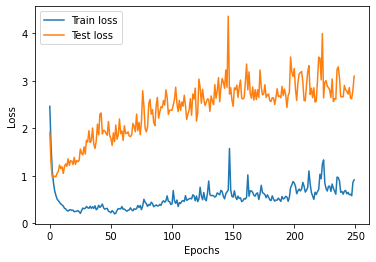

In [ ]:
plt.plot(train_loss_WordCNN_dropout,label="Train loss")
plt.plot(test_loss_WordCNN_dropout,label="Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

# CharRNN Model w/ Dropout

In [ ]:
class CharRNN(Model):

    def __init__(self, vocab_size=256, hidden_dim=10):
        super(CharRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        
        # Weight variables and RNN cell
        self.rnn = layers.RNN(tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        categorical_labels = to_categorical(x, self.vocab_size)
        encoding = self.rnn(categorical_labels)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
#Choose optimizer and loss function for training
loss_object_2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Select metrics to measure the loss and the accuracy of the model. 
#These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

CharRNN_dropout_model = CharRNN(256, HIDDEN_SIZE)

test_acc_CharRNN_dropout = []
train_acc_CharRNN_dropout = []
test_loss_CharRNN_dropout =[]
train_loss_CharRNN_dropout =[]

charRNN_dropout_timer = 0



for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    epoch_start_time = time.perf_counter()
    
    for images, labels in train_ds:
        train_step_2(CharRNN_dropout_model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step_2(CharRNN_dropout_model, images, labels, drop_rate=0)

    epoch_end_time = time.perf_counter()
    charRNN_dropout_timer = charRNN_dropout_timer + epoch_end_time - epoch_start_time
    
    test_acc_CharRNN_dropout.append(test_accuracy.result())
    train_acc_CharRNN_dropout.append(train_accuracy.result())
    test_loss_CharRNN_dropout.append(test_loss.result())
    train_loss_CharRNN_dropout.append(train_loss.result())

    if ( (epoch+1)%50 == 0 ): 
        print('[Epoch {}]'.format(epoch+1))
        print('⏵Train Loss: {}'.format(train_loss.result()))
        print('⏵Train Acc:  {}'.format(train_accuracy.result()))
        print('⏵Test Loss:  {}'.format(test_loss.result()))
        print('⏵Test Acc:   {}'.format(test_accuracy.result()))
        print('')

print('Time Taken: {} seconds.'.format(charRNN_dropout_timer))

[Epoch 50]
⏵Train Loss: 0.8812198042869568
⏵Train Acc:  0.6928571462631226
⏵Test Loss:  1.0688921213150024
⏵Test Acc:   0.6600000262260437

[Epoch 100]
⏵Train Loss: 0.702340841293335
⏵Train Acc:  0.7510714530944824
⏵Test Loss:  1.0419833660125732
⏵Test Acc:   0.7014285922050476

[Epoch 150]
⏵Train Loss: 0.6422063708305359
⏵Train Acc:  0.7751785516738892
⏵Test Loss:  1.1624189615249634
⏵Test Acc:   0.6985714435577393

[Epoch 200]
⏵Train Loss: 0.7242007255554199
⏵Train Acc:  0.758392870426178
⏵Test Loss:  1.158546805381775
⏵Test Acc:   0.6842857003211975

[Epoch 250]
⏵Train Loss: 0.5880512595176697
⏵Train Acc:  0.791607141494751
⏵Test Loss:  1.210943579673767
⏵Test Acc:   0.6857143044471741

Time Taken: 2163.4297472329963 seconds.


## Pickle Dump

In [ ]:
instanced_variables = [test_acc_CharRNN_dropout, train_acc_CharRNN_dropout, test_loss_CharRNN_dropout, train_loss_CharRNN_dropout, charRNN_dropout_timer]

# create directory in your gdrive
filename = f'/content/gdrive/My Drive/Colab Output/Part_B_Q5_CharRNN_Dropout_variables'
outfile = open(filename,'wb')
pickle.dump(instanced_variables, outfile)
outfile.close()

In [10]:
# Retrieve previously saved instanced variables w/ pickle rick
infile = open(f'/content/gdrive/My Drive/Colab Output/Part_B_Q5_CharRNN_Dropout_variables', 'rb')
retrieved_variables = pickle.load(infile)
infile.close()

# Load retrieved variables into instance variables for plotting
test_acc_CharRNN, train_acc_CharRNN, test_loss_CharRNN, train_loss_CharRNN, charRNN_timer = retrieved_variables

In [11]:
# get highest accuracy values
highest_acc = max(test_acc_CharRNN)

# get average accuracy
average_acc = sum(test_acc_CharRNN)/len(test_acc_CharRNN)

print('Highest Acc')
print(highest_acc)

print('')

print('Avg Acc')
print(average_acc)

Highest Acc
tf.Tensor(0.71428573, shape=(), dtype=float32)

Avg Acc
tf.Tensor(0.65677655, shape=(), dtype=float32)


## CharRNN Plot

### CharRNN Accuracy

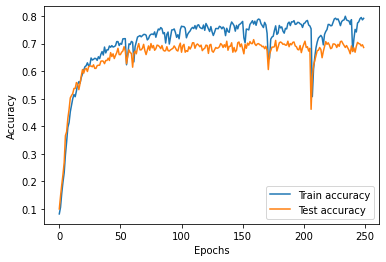

In [ ]:
plt.plot(train_acc_CharRNN_dropout,label="Train accuracy")
plt.plot(test_acc_CharRNN_dropout,label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

### CharRNN Loss

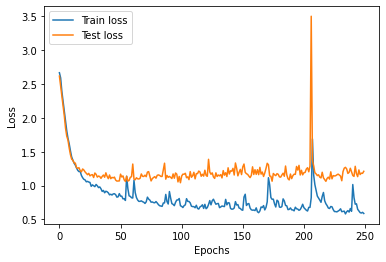

In [ ]:
plt.plot(train_loss_CharRNN_dropout,label="Train loss")
plt.plot(test_loss_CharRNN_dropout,label="Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

# WordRNN Model w/ Dropout

In [ ]:
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=10):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        
        # Weight variables and RNN cell
        self.rnn = layers.RNN(tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
#Choose optimizer and loss function for training
loss_object_2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Select metrics to measure the loss and the accuracy of the model. 
#These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

WordRNN_dropout_model = WordRNN(vocab_size_word, HIDDEN_SIZE)

test_acc_WordRNN_dropout = []
train_acc_WordRNN_dropout= []
test_loss_WordRNN_dropout= []
train_loss_WordRNN_dropout=[]

wordRNN_dropout_timer = 0



for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    epoch_start_time = time.perf_counter()
    
    for images, labels in train_ds_word:
        train_step_2(WordRNN_dropout_model, images, labels, drop_rate=0)

    for images, labels in test_ds_word:
        test_step_2(WordRNN_dropout_model, images, labels, drop_rate=0)

    epoch_end_time = time.perf_counter()
    wordRNN_dropout_timer = wordRNN_dropout_timer + epoch_end_time - epoch_start_time

    test_acc_WordRNN_dropout.append(test_accuracy.result())
    train_acc_WordRNN_dropout.append(train_accuracy.result())
    test_loss_WordRNN_dropout.append(test_loss.result())
    train_loss_WordRNN_dropout.append(train_loss.result())

    if ( (epoch+1)%50 == 0 ): 
        print('[Epoch {}]'.format(epoch+1))
        print('⏵Train Loss: {}'.format(train_loss.result()))
        print('⏵Train Acc:  {}'.format(train_accuracy.result()))
        print('⏵Test Loss:  {}'.format(test_loss.result()))
        print('⏵Test Acc:   {}'.format(test_accuracy.result()))
        print('')

print('Time Taken: {} seconds.'.format(wordRNN_dropout_timer))

[Epoch 50]
⏵Train Loss: 0.00020179124840069562
⏵Train Acc:  1.0
⏵Test Loss:  0.8662602305412292
⏵Test Acc:   0.8728571534156799

[Epoch 100]
⏵Train Loss: 4.0362010622629896e-05
⏵Train Acc:  1.0
⏵Test Loss:  1.0318496227264404
⏵Test Acc:   0.8728571534156799

[Epoch 150]
⏵Train Loss: 1.157717179012252e-05
⏵Train Acc:  1.0
⏵Test Loss:  1.1457751989364624
⏵Test Acc:   0.8728571534156799

[Epoch 200]
⏵Train Loss: 3.650930239018635e-06
⏵Train Acc:  1.0
⏵Test Loss:  1.2256264686584473
⏵Test Acc:   0.8771428465843201

[Epoch 250]
⏵Train Loss: 1.173395389741927e-06
⏵Train Acc:  1.0
⏵Test Loss:  1.326763391494751
⏵Test Acc:   0.8742856979370117

Time Taken: 2300.185826468989 seconds.


## Pickle Dump

In [ ]:
instanced_variables = [test_acc_WordRNN_dropout, train_acc_WordRNN_dropout, test_loss_WordRNN_dropout, train_loss_WordRNN_dropout, wordRNN_dropout_timer]

# create directory in your gdrive
filename = f'/content/gdrive/My Drive/Colab Output/Part_B_Q5_WordRNN_Dropout_variables'
outfile = open(filename,'wb')
pickle.dump(instanced_variables, outfile)
outfile.close()

In [13]:
# Retrieve previously saved instanced variables w/ pickle rick
infile = open(f'/content/gdrive/My Drive/Colab Output/Part_B_Q5_WordRNN_Dropout_variables', 'rb')
retrieved_variables = pickle.load(infile)
infile.close()

# Load retrieved variables into instance variables for plotting
test_acc_WordRNN, train_acc_WordRNN, test_loss_WordRNN, train_loss_WordRNN, wordRNN_timer = retrieved_variables

In [14]:
# get highest accuracy values
highest_acc = max(test_acc_WordRNN)

# get average accuracy
average_acc = sum(test_acc_WordRNN)/len(test_acc_WordRNN)

print('Highest Acc')
print(highest_acc)

print('')

print('Avg Acc')
print(average_acc)

Highest Acc
tf.Tensor(0.8842857, shape=(), dtype=float32)

Avg Acc
tf.Tensor(0.8657879, shape=(), dtype=float32)


## WordRNN Plot

### WordRNN Accuracy

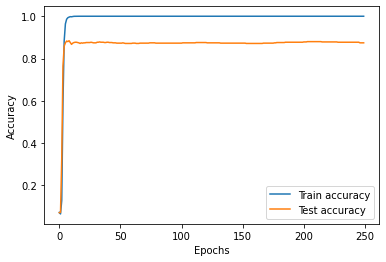

In [ ]:
plt.plot(train_acc_WordRNN_dropout,label="Train accuracy")
plt.plot(test_acc_WordRNN_dropout,label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()

### WordRNN Loss

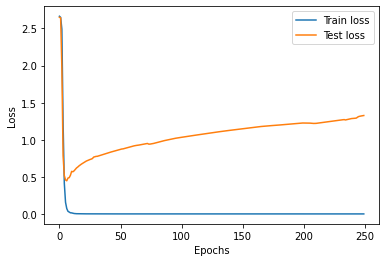

In [ ]:
plt.plot(train_loss_WordRNN_dropout,label="Train loss")
plt.plot(test_loss_WordRNN_dropout,label="Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()
plt.close()